In [ ]:


import zipfile
import os

zip_path = r"C:\Users\pavit\Downloads\archive (2).zip"
extract_dir = 'C:/Users/pavit/Desktop/extracted_files/'  # Ensure this path exists and is writable

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction completed.")

# Imports
import os

import torch
import torchvision
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
# Data

MANUAL_SEED = 42
BATCH_SIZE = 32
SHUFFLE = True

# Create dataset to load the images
class LandscapeDataset(Dataset):
    def __init__(self, transform=None):
        self.dataroot = './landscape Images'
        self.images = os.listdir(f'{self.dataroot}/color')
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image Paths
        img_path = self.images[idx]

        # Load the images
        color_img = read_image(f'{self.dataroot}/color/{img_path}') / 255
        gray_img = read_image(f'{self.dataroot}/gray/{img_path}') / 255

        if self.transform:
            color_img = self.transform(color_img)
            gray_img = self.transform(gray_img)

        return color_img, gray_img
transform = transforms.Compose([
    transforms.Resize((150, 150), antialias=False),
])
# Load the dataset
dataset = LandscapeDataset(transform=transform)

# Split the data into train and test data
train_set, test_set = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(MANUAL_SEED))

# Load the train and set data
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
# Visualize some images
def show_images(color, gray):
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    for i in range(5):
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 1].axis('off')
    plt.show()
    for color, gray in trainloader:
      show_images(color, gray)
      break

# Training Variables

EPOCHS = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.9
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# Create the autoencoder model
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(UNet, self).__init__()
        
        # Encoder layers
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        
        # Middle part
        self.middle = self.conv_block(512, 1024)
        
        # Decoder layers
        self.decoder4 = self.conv_block(1024, 512)
        self.decoder3 = self.conv_block(512, 256)
        self.decoder2 = self.conv_block(256, 128)
        self.decoder1 = self.conv_block(128, 64)
        
        # Final convolution to output the required number of channels (RGB in this case)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def conv_block(self, in_channels, out_channels):
        """Convolution block: two convolution layers followed by ReLU activations"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        """Forward pass of the U-Net"""
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))
        
        # Middle
        middle = self.middle(F.max_pool2d(enc4, 2))
        
        # Decoder (Upsample using bilinear interpolation)
        dec4 = self.decoder4(F.interpolate(middle, scale_factor=2, mode='bilinear', align_corners=True))
        dec3 = self.decoder3(F.interpolate(dec4, scale_factor=2, mode='bilinear', align_corners=True))
        dec2 = self.decoder2(F.interpolate(dec3, scale_factor=2, mode='bilinear', align_corners=True))
        dec1 = self.decoder1(F.interpolate(dec2, scale_factor=2, mode='bilinear', align_corners=True))
        
        # Upsample to match input size (150x150)
        output = F.interpolate(dec1, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=True)
        
        # Final convolution layer to get the output
        return self.final_conv(output)

# Initialize the model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=3).to(DEVICE)

# Fetch a batch of grayscale images from the DataLoader for testing
for _, (color_img, gray_img) in enumerate(trainloader):
    gray_img = gray_img.to(DEVICE)  # Move grayscale image batch to the same device as the model
    break  # Only take the first batch

# Ensure the input tensor has the correct shape, e.g., [batch_size, 1, height, width]
print(f"Input shape: {gray_img.shape}")

# Make predictions using the model
predictions = model(gray_img)

# Print the shape of the predictions to verify
print(f"Output shape: {predictions.shape}")


# Initialize the model

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
f"Total Number of trainable parameters of this model are: {total_params:,}"
# Initialize the optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Initialize lists to track loss during training
train_losses = []
test_losses = []
# Define the training loop
for epoch in range(EPOCHS):
    running_loss = 0.0
    for idx, (color_img, gray_img) in tqdm(enumerate(trainloader), total=len(trainloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        # Make model predictions
        predictions = model(gray_img)

        optimizer.zero_grad()
        # Calculate loss between coloured image and predicted image
        loss = criterion(color_img, predictions)

        # Calcuate gradients and back propagate
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch: {epoch + 1}, Loss: {running_loss:.6f}')

print('Training Finished!')

# Test on testing data
total_loss = 0.0
with torch.no_grad():
    for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total=len(testloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        prediction = model(gray_img)

        loss = criterion(prediction, color_img)
        total_loss += loss.item()

f"Total Testing loss is: {total_loss/ len(testloader):.3f}"
# Visualize some predictions
def show_predictions(color, gray, pred):
    fig, axs = plt.subplots(5, 3, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    axs[0, 2].set_title('Predicted')
    for i in range(5):
        axs[i, 0].axis('off')
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 2].axis('off')
        axs[i, 2].imshow(pred[i].permute(1,2,0))
    plt.show()
show_predictions( color_img.cpu(), gray_img.cpu(),prediction.detach().cpu())


Extraction completed.
Input shape: torch.Size([32, 1, 150, 150])
Output shape: torch.Size([32, 3, 150, 150])


  0%|          | 0/179 [00:00<?, ?it/s]

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(UNet, self).__init__()
        
        # Encoder layers
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        
        # Middle part
        self.middle = self.conv_block(512, 1024)
        
        # Decoder layers
        self.decoder4 = self.conv_block(1024, 512)
        self.decoder3 = self.conv_block(512, 256)
        self.decoder2 = self.conv_block(256, 128)
        self.decoder1 = self.conv_block(128, 64)
        
        # Final convolution to output the required number of channels (RGB in this case)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def conv_block(self, in_channels, out_channels):
        """Convolution block: two convolution layers followed by ReLU activations"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        """Forward pass of the U-Net"""
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))
        
        # Middle
        middle = self.middle(F.max_pool2d(enc4, 2))
        
        # Decoder (Upsample using bilinear interpolation)
        dec4 = self.decoder4(F.interpolate(middle, scale_factor=2, mode='bilinear', align_corners=True))
        dec3 = self.decoder3(F.interpolate(dec4, scale_factor=2, mode='bilinear', align_corners=True))
        dec2 = self.decoder2(F.interpolate(dec3, scale_factor=2, mode='bilinear', align_corners=True))
        dec1 = self.decoder1(F.interpolate(dec2, scale_factor=2, mode='bilinear', align_corners=True))
        
        # Upsample to match input size (150x150)
        output = F.interpolate(dec1, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=True)
        
        # Final convolution layer to get the output
        return self.final_conv(output)

# Initialize the model with 1 input channel for grayscale images
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=3).to(DEVICE)

# Assuming `gray_img` is your input tensor, make sure it's in the right shape
gray_img = gray_img.to(DEVICE)  # Move image to the same device as the model

# Ensure the input tensor has the correct shape, e.g., [batch_size, 1, height, width]
print(f"Input shape: {gray_img.shape}")

# Make predictions using the model
predictions = model(gray_img)

# Print the shape of the predictions to verify
print(f"Output shape: {predictions.shape}")


Input shape: torch.Size([32, 1, 150, 150])
Output shape: torch.Size([32, 3, 150, 150])


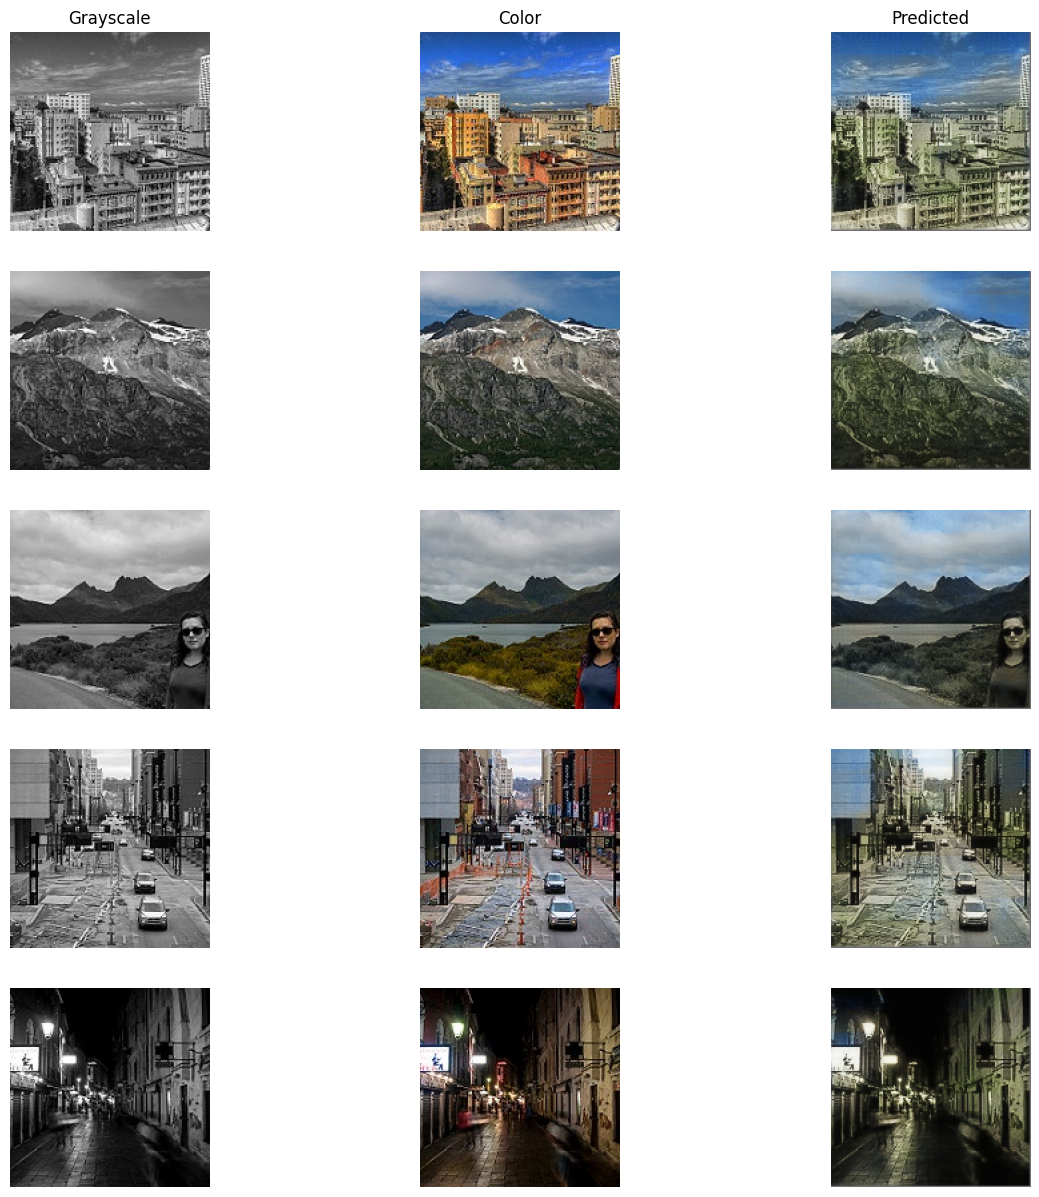

In [137]:
def show_predictions(color, gray, pred):
    fig, axs = plt.subplots(5, 3, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    axs[0, 2].set_title('Predicted')
    for i in range(5):
        axs[i, 0].axis('off')
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 2].axis('off')
        axs[i, 2].imshow(pred[i].permute(1,2,0))
    plt.show()
show_predictions( color_img.cpu(), gray_img.cpu(),prediction.detach().cpu())

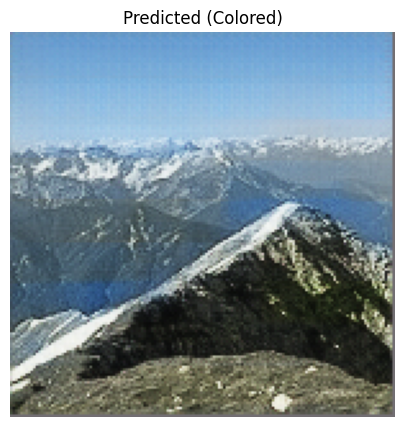

In [143]:
import matplotlib.pyplot as plt

def show_single_colored_prediction(pred, index=0):
    plt.figure(figsize=(5, 5))
    plt.title('Predicted (Colored)')
    
    # Apply colormap to the predicted image if it's grayscale (2D)
    if pred[index].dim() == 2:  # If the predicted image is grayscale (single channel)
        plt.imshow(pred[index], cmap='jet')  # Using 'jet' colormap for colorization
    else:
        plt.imshow(pred[index].permute(1, 2, 0))  # Assuming it's already a color image
        
    plt.axis('off')  # Hide axis
    plt.show()

# Call the function with the index for the image you want to display
show_single_colored_prediction(prediction.detach().cpu(), index=11)


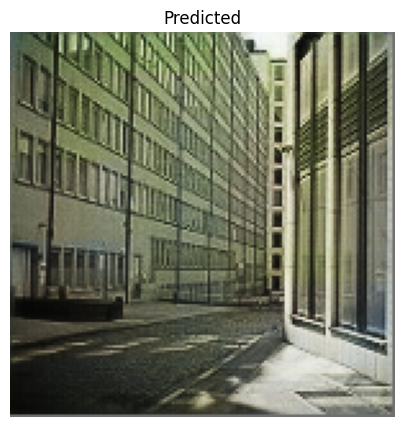

In [152]:
import matplotlib.pyplot as plt

def show_single_prediction(pred, index=0):
    plt.figure(figsize=(5, 5))
    plt.title('Predicted')
    plt.axis('off')
    plt.imshow(pred[index].permute(1, 2, 0))
    plt.show()

# Call the function with the index for the image you want to display
show_single_prediction(prediction.detach().cpu(), index=12)


In [129]:
import torch
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm

# PSNR Calculation
def calculate_psnr(original, predicted, max_pixel_value=1.0):
    mse = torch.mean((original - predicted) ** 2)
    if mse == 0:
        return 100  # Max PSNR for identical images
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr.item()

# Testing and calculating PSNR and MSE (no SSIM)
total_psnr = 0.0
total_loss = 0.0

with torch.no_grad():
    for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total=len(testloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        prediction = model(gray_img)

        # Calculate MSE
        mse_value = criterion(prediction, color_img).item()
        total_loss += mse_value

        # Calculate PSNR
        psnr_value = calculate_psnr(color_img, prediction)
        total_psnr += psnr_value

# Average loss and PSNR
avg_loss = total_loss / len(testloader)
avg_psnr = total_psnr / len(testloader)

print(f"Average Loss: {avg_loss:.3f}")
print(f"Average PSNR: {avg_psnr:.3f} dB")


100%|██████████| 45/45 [00:16<00:00,  2.65it/s]

Average Loss: 0.007
Average PSNR: 21.733 dB


In [131]:
# Testing on testing data
total_loss = 0.0
total_psnr = 0.0

with torch.no_grad():  # No gradients required for testing
    for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total=len(testloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        # Get model prediction
        prediction = model(gray_img)

        # Calculate loss (e.g., MSE loss)
        loss = criterion(prediction, color_img)
        total_loss += loss.item()

        # Calculate PSNR
        psnr_value = calculate_psnr(color_img, prediction)
        total_psnr += psnr_value

# Calculate average loss and PSNR
avg_loss = total_loss / len(testloader)
avg_psnr = total_psnr / len(testloader)

# Get current learning rate (you can use the same approach as during training)
current_lr = optimizer.param_groups[0]['lr']

# Print the total test loss, average PSNR, and learning rate
print(f"Total Test Loss: {avg_loss:.3f}")
print(f"Average PSNR on Test Data: {avg_psnr:.3f}")
print(f"Learning Rate: {current_lr:.6f}")


100%|██████████| 45/45 [00:16<00:00,  2.67it/s]

Total Test Loss: 0.007
Average PSNR on Test Data: 21.752
Learning Rate: 0.001000


In [130]:
# Test on testing data
total_loss = 0.0
output_shapes = []  # To store the output shapes for analysis

with torch.no_grad():
    for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total=len(testloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        prediction = model(gray_img)

        # Collect output dimensionality
        output_shapes.append(prediction.shape)

        # Calculate loss
        loss = criterion(prediction, color_img)
        total_loss += loss.item()

print(f"Total Testing loss is: {total_loss / len(testloader):.3f}")

# Print or analyze the output shapes
print(f"Dimensionality of a single output: {output_shapes[0]}")


100%|██████████| 45/45 [00:16<00:00,  2.74it/s]

Total Testing loss is: 0.007
Dimensionality of a single output: torch.Size([32, 3, 150, 150])
